In [17]:
# Выполните сохранение монохромного изображения в виде текстового или бинарного файла.
# Реализуйте алгоритм вейвлет-преобразования Хаара для изображения.
# Выполните квантование высокочастотных компонент (прим., количество квантов = 4).
#Сохраните получившийся массив значений в текстовый или бинарный файл в порядке LL, LH, HL, HH вейвлет-преобразования Хафа. Компоненты LH, HL, HH храните в виде пар (значение, количество повторений).
# Сравните объем памяти, занимаемый исходным изображением (попиксельное хранение), и изображение, полученным после преобразования Хафа и сжатием длин серий.

1. Сохранение монохромного текста

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
img = cv2.imread('sar_1.jpg', cv2.IMREAD_GRAYSCALE)
if img is None:
    print("Ошибка при загрузке изображения.")
else:
    _, monoImg = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)

    #сохранение монохромного изображения в текстовый файл
    with open('monochrome_Img.txt', 'w') as file:
        for r in monoImg:
            line = ' '.join(str(pixel) for pixel in r)
            file.write(line + '\n')

2. Алгоритм вейвлет-преобразование Хаара

In [7]:
def wavelet_haar(data):
    data = data.astype(np.float32)
    rows, cols = data.shape
    horizontal = np.zeros_like(data)


    for row_idx in range(rows):
        col_idx = 0
        while col_idx < cols - 1:
            pixel1 = data[row_idx, col_idx]
            pixel2 = data[row_idx, col_idx + 1]

            average = (pixel1 + pixel2) / 2.0
            difference = (pixel1 - pixel2) / 2.0

            horizontal[row_idx, col_idx // 2] = average
            horizontal[row_idx, col_idx // 2 + cols // 2] = difference

            col_idx += 2

        if cols % 2 != 0:
            horizontal[row_idx, cols // 2] = data[row_idx, -1]

    vertical = np.zeros_like(horizontal)

    for col_idx in range(cols):
        row_idx = 0
        while row_idx < rows - 1:
            pixel1 = horizontal[row_idx, col_idx]
            pixel2 = horizontal[row_idx + 1, col_idx]

            average = (pixel1 + pixel2) / 2.0
            difference = (pixel1 - pixel2) / 2.0

            vertical[row_idx // 2, col_idx] = average
            vertical[row_idx // 2 + rows // 2, col_idx] = difference

            row_idx += 2

        if rows % 2 != 0:
            vertical[rows // 2, col_idx] = horizontal[-1, col_idx]

    half_rows = rows // 2
    half_cols = cols // 2

    ll_component = vertical[:half_rows, :half_cols]
    lh_component = vertical[:half_rows, half_cols:]
    hl_component = vertical[half_rows:, :half_cols]
    hh_component = vertical[half_rows:, half_cols:]

    return ll_component, lh_component, hl_component, hh_component, vertical

LL, LH, HL, HH, full_transform = wavelet_haar(img)

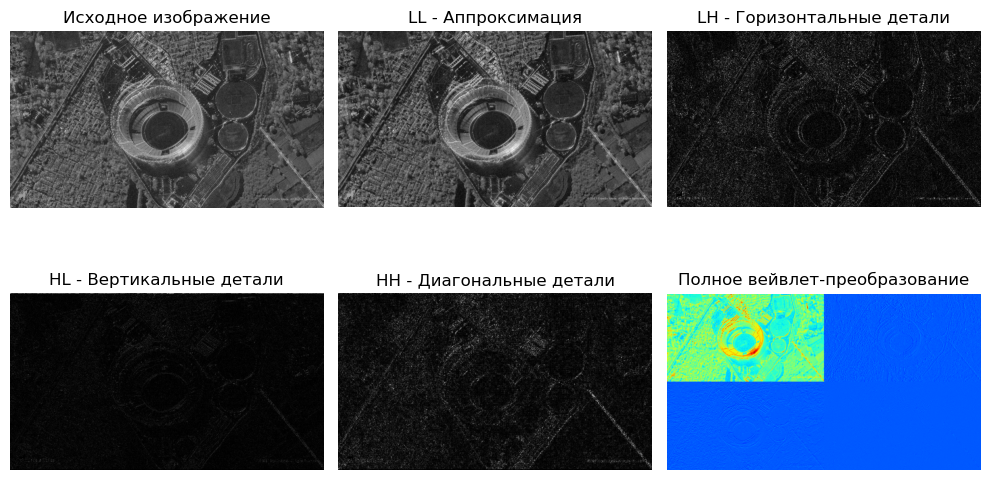

In [9]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')

# LL
plt.subplot(2, 3, 2)
plt.imshow(LL, cmap='gray')
plt.title('LL - Аппроксимация')
plt.axis('off')

# LH 
plt.subplot(2, 3, 3)
plt.imshow(np.abs(LH), cmap='gray')
plt.title('LH - Горизонтальные детали')
plt.axis('off')

# HL 
plt.subplot(2, 3, 4)
plt.imshow(np.abs(HL), cmap='gray')
plt.title('HL - Вертикальные детали')
plt.axis('off')

# HH 
plt.subplot(2, 3, 5)
plt.imshow(np.abs(HH), cmap='gray')
plt.title('HH - Диагональные детали')
plt.axis('off')

#полнон
plt.subplot(2, 3, 6)
plt.imshow(full_transform, cmap='jet')
plt.title('Полное вейвлет-преобразование')
plt.axis('off')

plt.tight_layout()
plt.show()

3. Квантование высокочастотных компонентов

In [3]:
def quantize(coeffs, n_quants):
    min_val = np.min(coeffs)
    max_val = np.max(coeffs)
    step = (max_val - min_val) / n_quants
    quantized = np.round((coeffs - min_val) / step).astype(int)
    return quantized, min_val, step

num_quants = 4
lh_quantize, lh_min, lh_step = quantize(LH, num_quants)
hl_quantize, hl_min, hl_step = quantize(HL, num_quants)
hh_quantize, hh_min, hh_step = quantize(HH, num_quants)

def dequantize(quantized, min_val, step):
    return min_val + quantized * step

lh_restored = dequantize(lh_quantize, lh_min, lh_step)
hl_restored = dequantize(hl_quantize, hl_min, hl_step)
hh_restored = dequantize(hh_quantize, hh_min, hh_step)

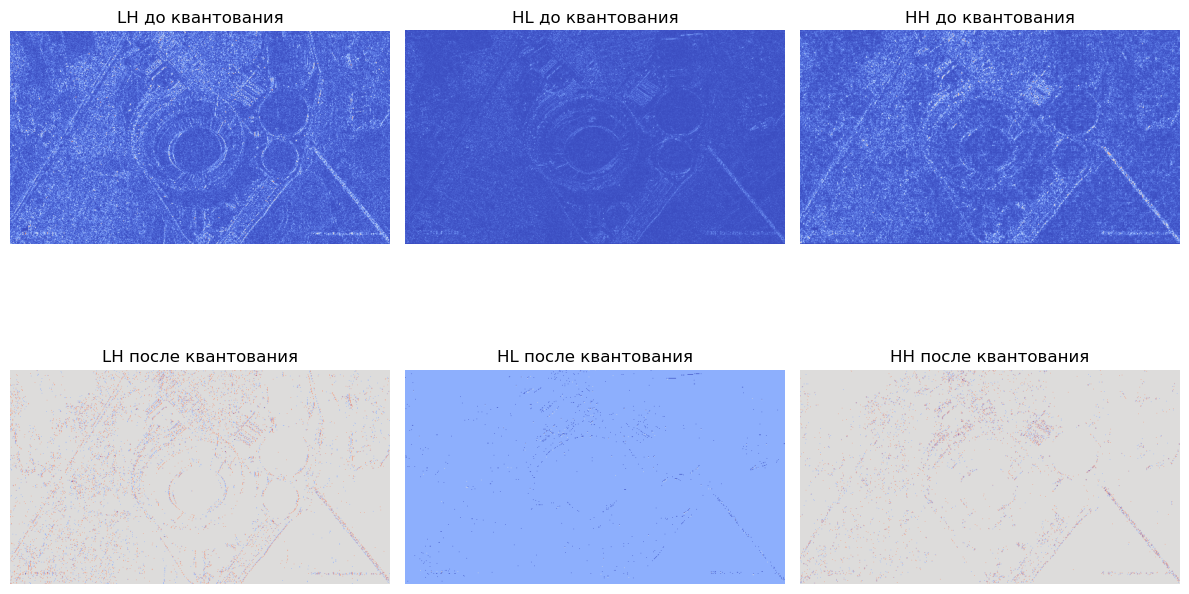

In [11]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(np.abs(LH), cmap='coolwarm')
plt.title('LH до квантования')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(np.abs(HL), cmap='coolwarm')
plt.title('HL до квантования')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(np.abs(HH), cmap='coolwarm')
plt.title('HH до квантования')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(lh_restored, cmap='coolwarm')
plt.title('LH после квантования')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(hl_restored, cmap='coolwarm')
plt.title('HL после квантования')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(hh_restored, cmap='coolwarm')
plt.title('HH после квантования')
plt.axis('off')

plt.tight_layout()
plt.show()

4. Сохраните получившийся массив значений в текстовый или бинарный файл в порядке LL, LH, HL, HH вейвлет-преобразования Хафа. Компоненты LH, HL, HH храните в виде пар (значение, количество повторений)

In [15]:
def encode_rle(comp_data):
    rle_result = []
    for val, cnt in Counter(comp_data.flatten()).items():
        rle_result.append((val, cnt))
    return rle_result

lh_encoded = encode_rle(lh_quantize)
hl_encoded = encode_rle(hl_quantize)
hh_encoded = encode_rle(hh_quantize)

with open('haar.txt', 'w') as file:
    np.savetxt(file, LL, fmt='%d')
    file.write('\n')
    high_freq = [('LH', lh_encoded), ('HL', hl_encoded), ('HH', hh_encoded)]

    for name, encoded_data in high_freq:
        for val, cnt in encoded_data:
            file.write(f"{val} {cnt}\n")
        file.write('\n')

5. Сравнение объема памяти

In [16]:
with open('monochrome_Img.txt', 'r') as f:
    o_size = len(f.read().encode('utf-8'))

with open('haar.txt', 'r') as f:
    h_size = len(f.read().encode('utf-8'))

print(f"Монохромное изображение занимает {o_size} байт")
print(f"Изображение, обработанное преобразованием Хаара занимает {h_size} байт")
print(f"Сжали в {o_size/h_size:.1f} раза")

Монохромное изображение занимает 1735428 байт
Изображение, обработанное преобразованием Хаара занимает 649344 байт
Сжали в 2.7 раза
